In [1]:
import os
import sys

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/raul.sanchez/data_scientia/rulo_mota_omath


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap

from src.features import cnbv_inclusion_financiera
from src.data import banxico_mun_income_remittances

In [3]:
remittances_df = banxico_mun_income_remittances.get()
remittances_df

remittances_df['remittance_id'] = (
    remittances_df['Municipality ID'].astype(str)
) + '-' + (
    remittances_df['Year'].astype(str))

y_true = remittances_df.set_index('remittance_id')['Remittance Amount']
y_true = np.log1p(y_true)

In [4]:
data_paths = dict(
    (x.split('/')[-1], x)
    for x in cnbv_inclusion_financiera.list_datasets())

list(data_paths.keys())

['BD Género Mun.csv',
 'BD Tenencia Uso Banca Mun.csv',
 'BD Infraestructura Mun.csv',
 'BD Tenencia Uso EACP Mun.csv',
 'Municipios.csv',
 'BD Uso Banca Mun.csv',
 'BD Acceso Mun.csv',
 'BD Uso Mun.csv',
 'BD Uso EACP Mun.csv']

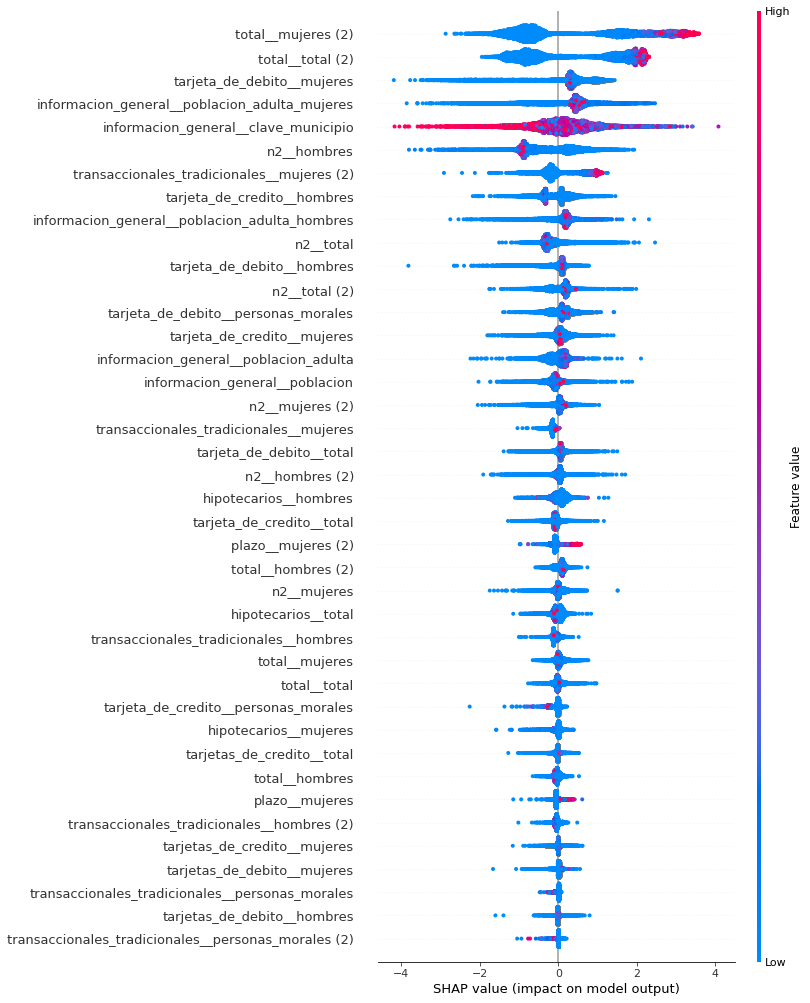

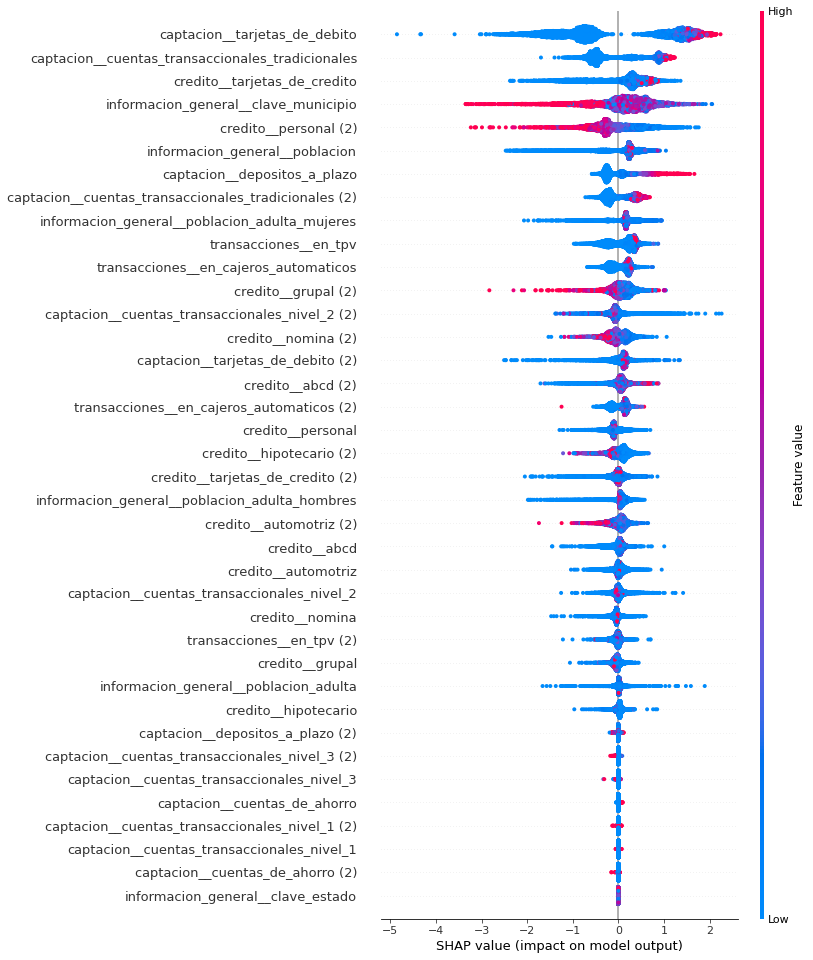

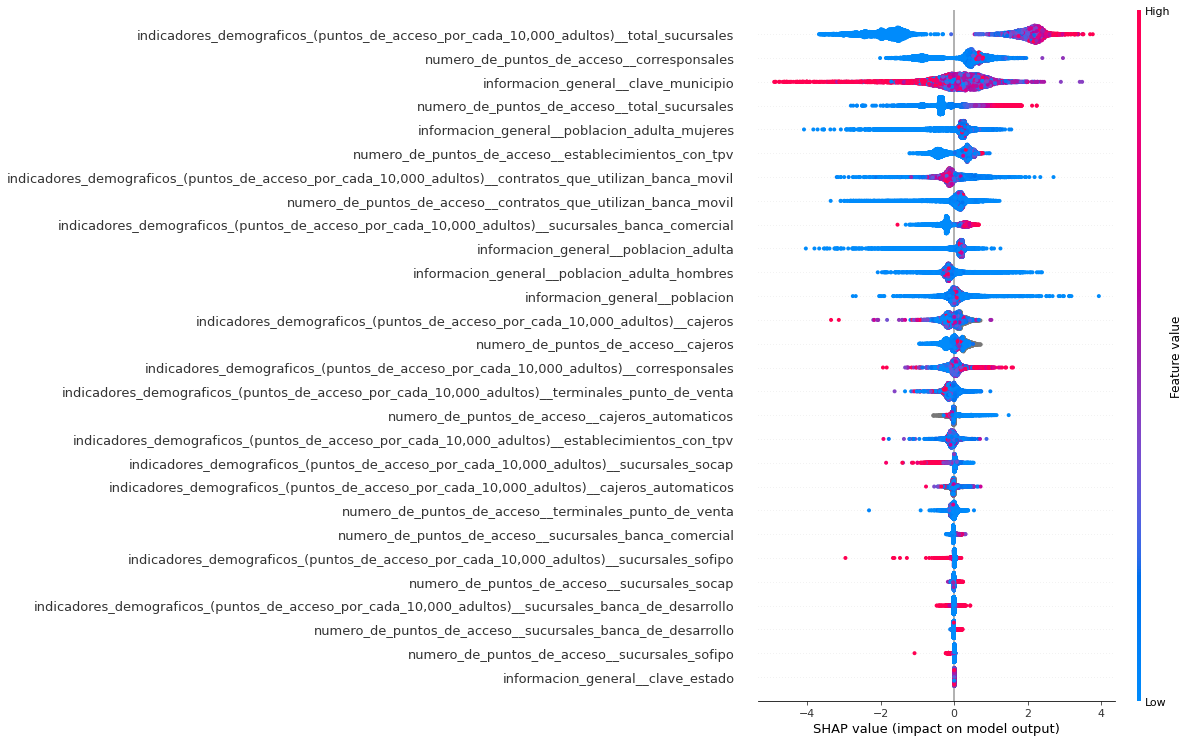

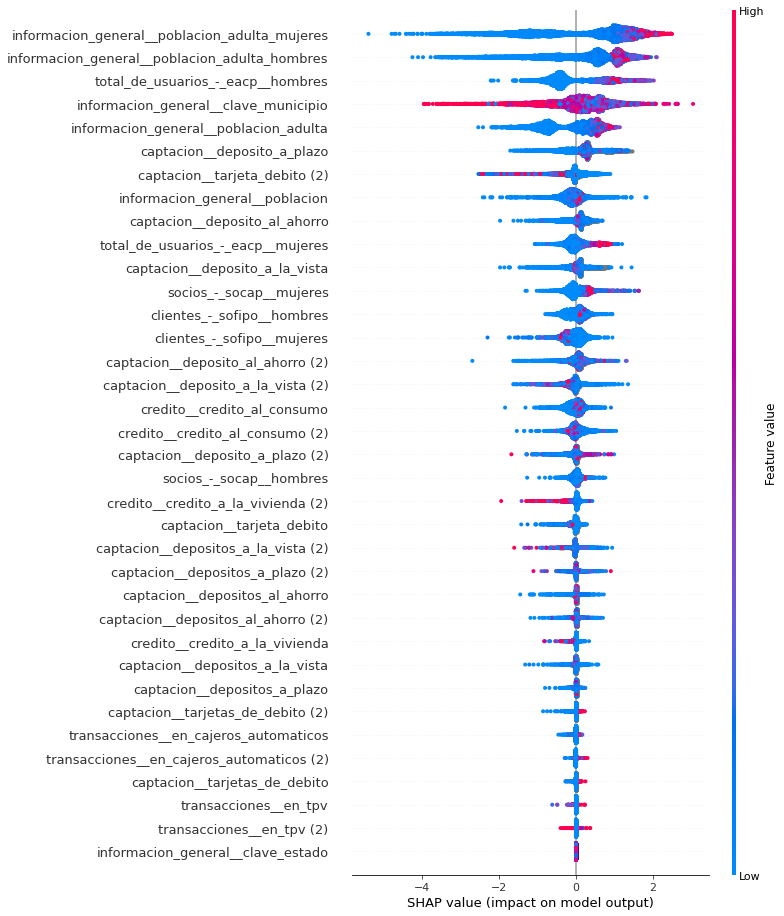

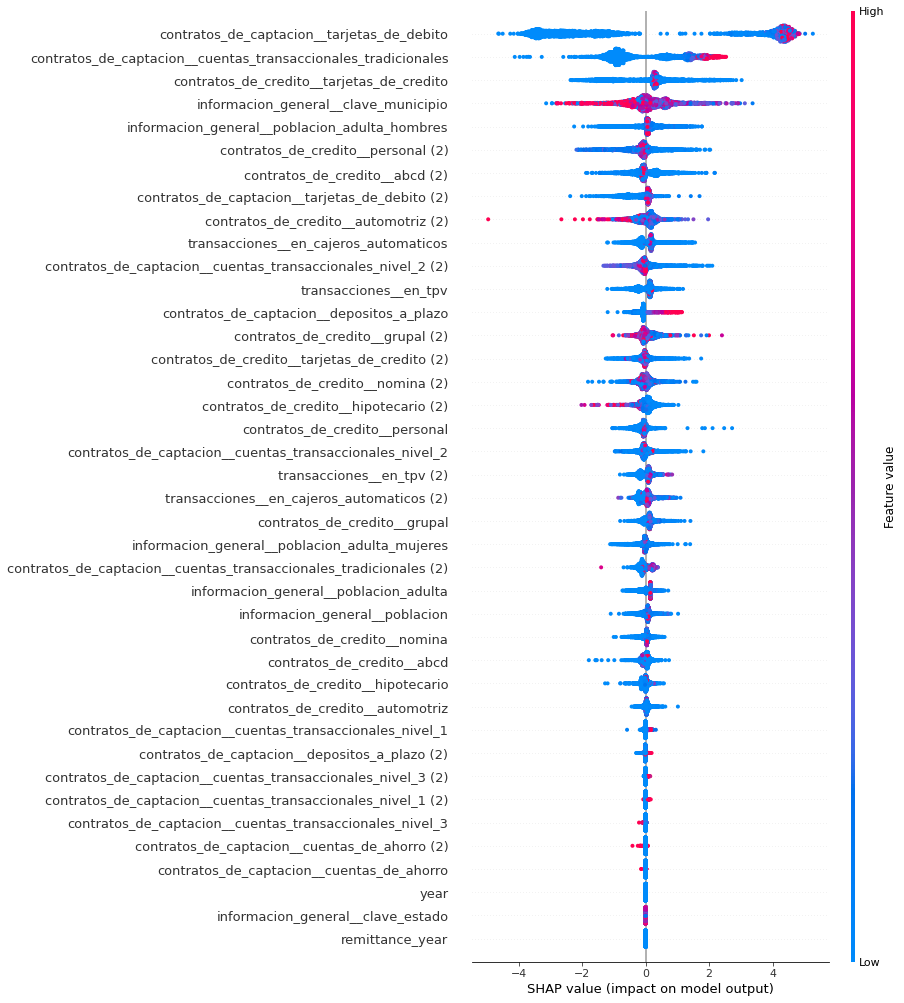

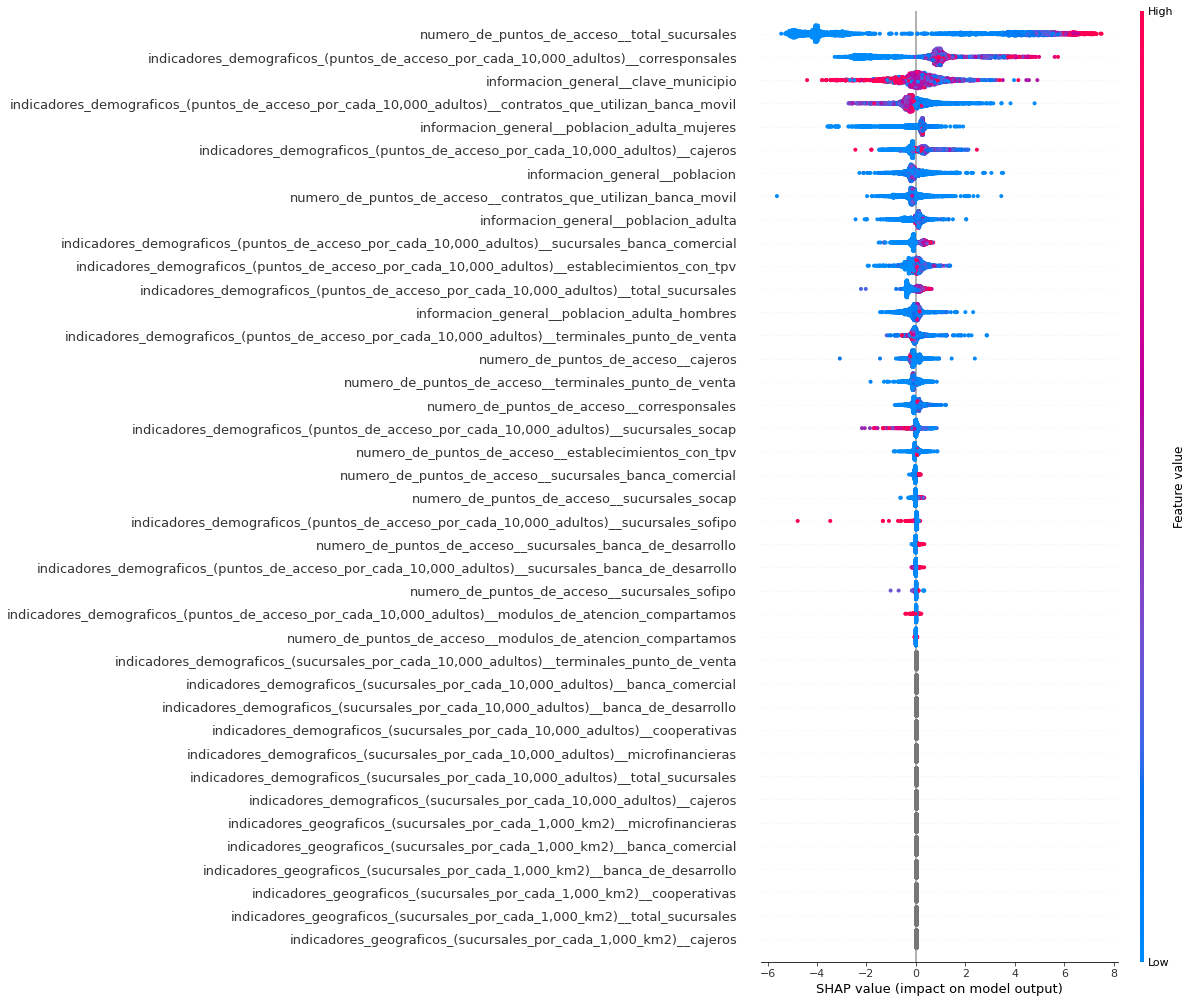

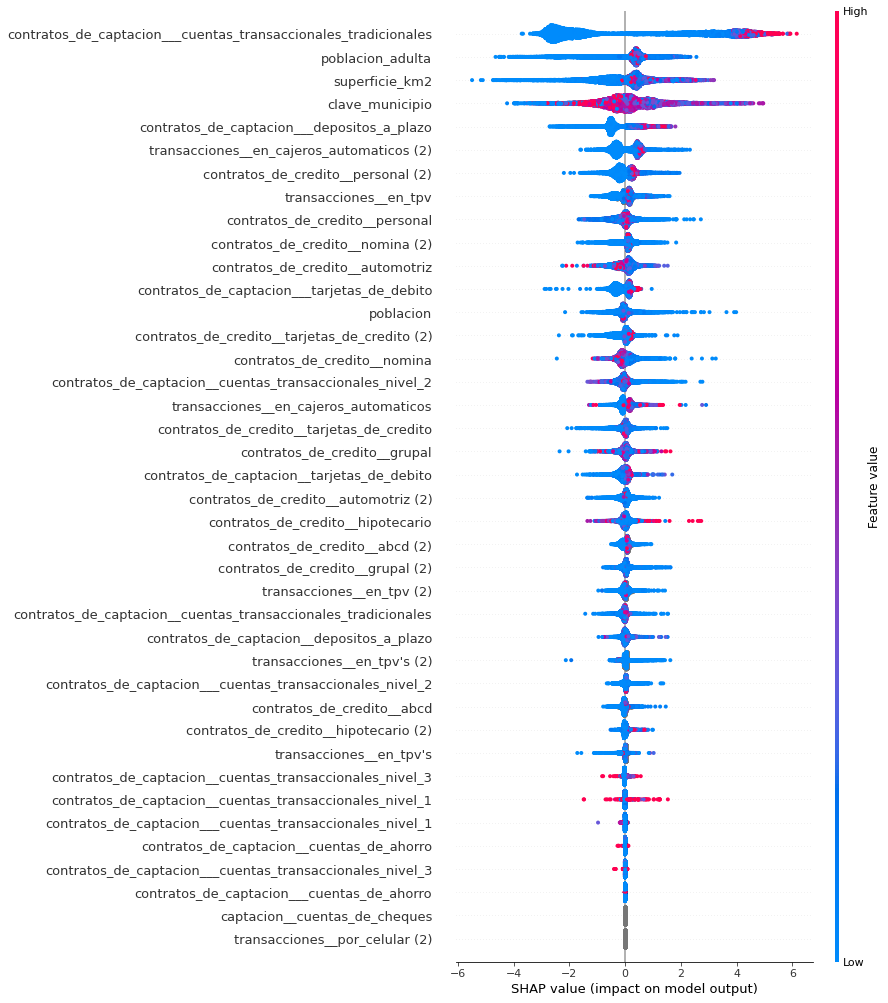

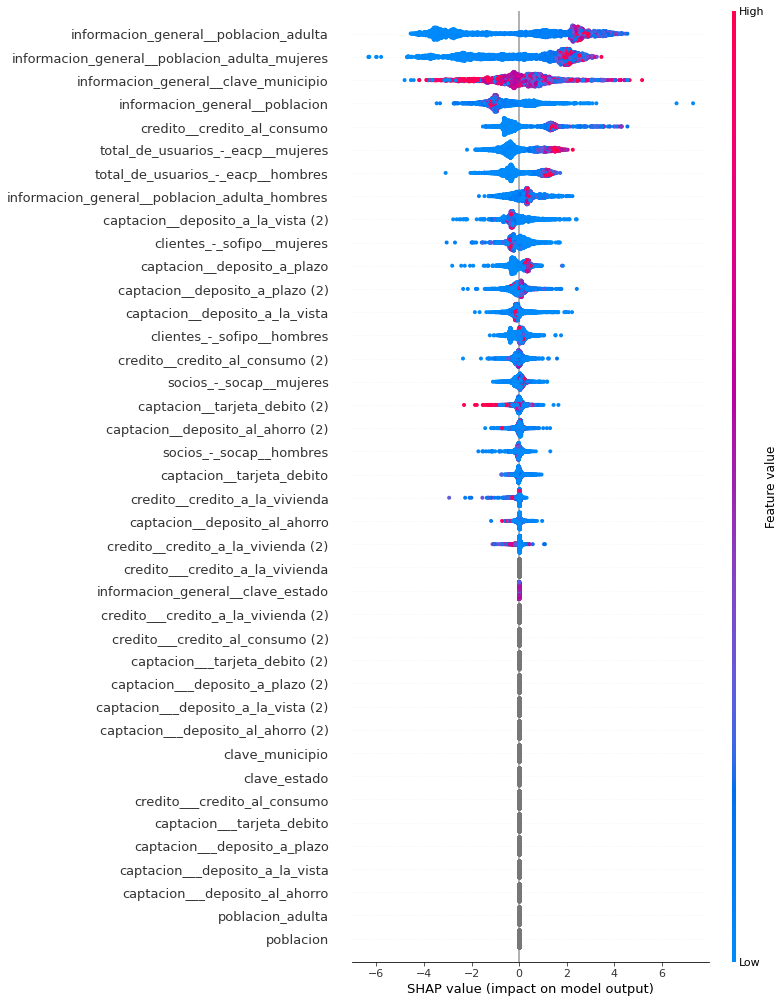

In [15]:
for dataset_name, path in data_paths.items():
    if dataset_name == 'Municipios.csv':
        continue
        
    data = pd.read_csv(path)
    data['name'] = data['name'].apply(lambda x: x.replace('%20', '_'))

    if 'informacion_general__clave_municipio' in data.columns:
        municipio_feature = 'informacion_general__clave_municipio'
    elif 'clave_de_estado_y_municipio' in data.columns:
        municipio_feature = 'clave_de_estado_y_municipio'
    else:
        municipio_feature = 'clave_municipio'
        
    data = data[data[municipio_feature].notnull()]
    data['remittance_id'] = data[municipio_feature].astype(int).astype(str)

    data['year'] = data['name'].apply(
        lambda x: x.split('_')[-1].replace('.csv', '')[:4]
    ).astype(int)
    data['remittance_year'] = data['year'] - 1
    data['remittance_id'] += '-' + data['remittance_year'].astype(str)

    data.drop_duplicates('remittance_id', keep='first', inplace=True)
    data.set_index('remittance_id', inplace=True)

    valid_idxs = set(data.index).intersection(y_true.index)
    X = data.loc[valid_idxs].select_dtypes(['float', 'int'])
    y = y_true.loc[valid_idxs]

    model = XGBRegressor(
        learning_rate=0.1, 
        max_depth=8, 
        n_estimators=1000)

    model.fit(X, y)
    
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(
        X, 
        check_additivity=False)

    shap.summary_plot(
        shap_values, X, 
        max_display=40)